# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = graphlab.SFrame('kc_house_data.gl/')

[INFO] This non-commercial license of GraphLab Create is assigned to kcbighuge@gmail.com and will expire on October 25, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-13031 - Server binary: /Users/jjl/.graphlab/anaconda/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1454301823.log
[INFO] GraphLab Server Version: 1.8.1


# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [22]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']
print len(all_features)

17


Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [13]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

PROGRESS: Linear regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 21613
PROGRESS: Number of features          : 17
PROGRESS: Number of unpacked features : 17
PROGRESS: Number of coefficients    : 18
PROGRESS: Starting Accelerated Gradient (FISTA)
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: Tuning step size. First iteration could take longer than subsequent iterations.
PROGRESS: | 1         | 2        | 0.000002  | 1.523467     | 6962915.603493     | 426631.749026 |
PROGRESS: | 2         | 3        | 0.000002  | 1.566143     | 6843144.200219     | 392488.929838 |
PROGRESS: | 3         | 4      

Find what features had non-zero weight.

In [21]:
model_all.coefficients[model_all.coefficients['value']==0].print_rows(num_rows=len(model_all.coefficients))

+-----------------+-------+-------+--------+
|       name      | index | value | stderr |
+-----------------+-------+-------+--------+
|     bedrooms    |  None |  0.0  |  None  |
| bedrooms_square |  None |  0.0  |  None  |
|     sqft_lot    |  None |  0.0  |  None  |
|  sqft_lot_sqrt  |  None |  0.0  |  None  |
|      floors     |  None |  0.0  |  None  |
|  floors_square  |  None |  0.0  |  None  |
|    waterfront   |  None |  0.0  |  None  |
|       view      |  None |  0.0  |  None  |
|    condition    |  None |  0.0  |  None  |
|  sqft_basement  |  None |  0.0  |  None  |
|     yr_built    |  None |  0.0  |  None  |
|   yr_renovated  |  None |  0.0  |  None  |
+-----------------+-------+-------+--------+
[12 rows x 4 columns]



In [25]:
model_all.coefficients[model_all.coefficients['value']!=0][:]

name,index,value,stderr
(intercept),None,274873.05595,None
bathrooms,None,8468.53108691,None
sqft_living,None,24.4207209824,None
sqft_living_sqrt,None,350.060553386,None
grade,None,842.068034898,None
sqft_above,None,20.0247224171,None


Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [120]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [28]:
import numpy as np
l1_search = np.logspace(1, 7, num=13)

In [139]:
def model_l1(train_data=training, valid_data=validation, l1_penalty=10., output_name='price', features_list=all_features):
    model = graphlab.linear_regression.create(train_data, target = output_name, features = features_list, \
                                              validation_set = None, verbose = False, l1_penalty=l1_penalty, l2_penalty=0.)
    e = compute_rss(model.predict(valid_data[features_list]), valid_data[output_name])
    print 'L1 ', l1_penalty, ':', e
    return e

def compute_rss(pred, actual):
    return sum((pred-actual)**2)

In [140]:
y = []
for i in l1_search:
    y.append(model_l1(l1_penalty=i))

L1  10.0 : 6.25766285142e+14
L1  31.6227766017 : 6.25766285362e+14
L1  100.0 : 6.25766286058e+14
L1  316.227766017 : 6.25766288257e+14
L1  1000.0 : 6.25766295212e+14
L1  3162.27766017 : 6.25766317206e+14
L1  10000.0 : 6.25766386761e+14
L1  31622.7766017 : 6.25766606749e+14
L1  100000.0 : 6.25767302792e+14
L1  316227.766017 : 6.25769507644e+14
L1  1000000.0 : 6.25776517727e+14
L1  3162277.66017 : 6.25799062845e+14
L1  10000000.0 : 6.25883719085e+14


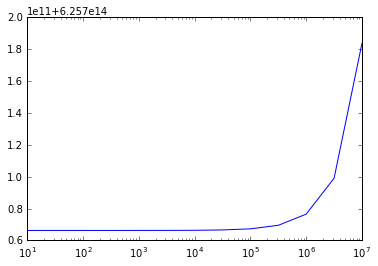

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(l1_search, y)
plt.xscale('log')
plt.show()

*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

In [103]:
best = np.argmin(y)
print l1_search[best]

10.0


In [229]:
test_model = graphlab.linear_regression.create(training, target = 'price', features = all_features, \
                                               validation_set = None, verbose = False, l1_penalty=10.0, l2_penalty=0.)
print sum((test_model.predict(testing[all_features]) - testing['price'])**2)

1.56983602382e+14


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [230]:
test_model.get("coefficients").print_rows(num_rows=18)

+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |  18993.4272128   |  None  |
|     bedrooms     |  None |  7936.96767903   |  None  |
| bedrooms_square  |  None |  936.993368193   |  None  |
|    bathrooms     |  None |  25409.5889341   |  None  |
|   sqft_living    |  None |  39.1151363797   |  None  |
| sqft_living_sqrt |  None |  1124.65021281   |  None  |
|     sqft_lot     |  None | 0.00348361822299 |  None  |
|  sqft_lot_sqrt   |  None |  148.258391011   |  None  |
|      floors      |  None |   21204.335467   |  None  |
|  floors_square   |  None |  12915.5243361   |  None  |
|    waterfront    |  None |  601905.594545   |  None  |
|       view       |  None |  93312.8573119   |  None  |
|    condition     |  None |  6609.03571245   |  None  |
|      grade       |  None |  6206.93999188   |  None  |
|    sqft_above    |  None |  4

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [145]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [146]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [147]:
def model_coeffs(train_data=training, valid_data=validation, l1_penalty=10., output_name='price', features_list=all_features):
    model = graphlab.linear_regression.create(train_data, target = output_name, features = features_list, \
                                              validation_set = None, verbose = False, l1_penalty=l1_penalty, l2_penalty=0.)
    e = compute_rss(model.predict(valid_data[features_list]), valid_data[output_name])
    coeffs = model['coefficients']['value']
    print 'L1 ', l1_penalty, ':', coeffs.nnz() , e
    return e, coeffs, coeffs.nnz()

In [148]:
y = []
nonzeros = []
coeffs = []
for i in l1_penalty_values:
    rss_error, weights, nz_params = model_coeffs(l1_penalty=i)
    y.append(rss_error)
    nonzeros.append(nz_params)
    coeffs.append(weights)

L1  100000000.0 : 18 6.27492659875e+14
L1  127427498.57 : 18 6.28210516771e+14
L1  162377673.919 : 18 6.29176689541e+14
L1  206913808.111 : 18 6.30650082719e+14
L1  263665089.873 : 17 6.32940229287e+14
L1  335981828.628 : 17 6.3626814023e+14
L1  428133239.872 : 17 6.41261198311e+14
L1  545559478.117 : 17 6.48983455376e+14
L1  695192796.178 : 17 6.60962217696e+14
L1  885866790.41 : 16 6.77261520728e+14
L1  1128837891.68 : 15 7.01046815867e+14
L1  1438449888.29 : 15 7.37850622829e+14
L1  1832980710.83 : 13 7.9616310964e+14
L1  2335721469.09 : 12 8.69018172894e+14
L1  2976351441.63 : 10 9.66925692362e+14
L1  3792690190.73 : 6 1.08186759232e+15
L1  4832930238.57 : 5 1.24492736032e+15
L1  6158482110.66 : 3 1.38416149024e+15
L1  7847599703.51 : 1 1.23079472046e+15
L1  10000000000.0 : 1 1.22915716064e+15


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [184]:
l1_penalty_min = np.max(l1_penalty_values[[i for i in range(len(nonzeros)) if nonzeros[i] >max_nonzeros]])
l1_penalty_max = np.min(l1_penalty_values[[i for i in range(len(nonzeros)) if nonzeros[i] <max_nonzeros]])

In [185]:
print l1_penalty_min
print l1_penalty_max

2976351441.63
3792690190.73


***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [186]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

In [187]:
y = []
nonzeros = []
coeffs = []
for i in l1_penalty_values:
    rss_error, weights, nz_params = model_coeffs(l1_penalty=i)
    y.append(rss_error)
    nonzeros.append(nz_params)
    coeffs.append(weights)

L1  2976351441.63 : 10 9.66925692362e+14
L1  3019316638.95 : 10 9.74019450085e+14
L1  3062281836.27 : 10 9.81188367942e+14
L1  3105247033.59 : 10 9.89328342459e+14
L1  3148212230.92 : 10 9.98783211266e+14
L1  3191177428.24 : 10 1.00847716702e+15
L1  3234142625.56 : 10 1.01829878055e+15
L1  3277107822.88 : 10 1.02824799221e+15
L1  3320073020.2 : 8 1.03461690923e+15
L1  3363038217.52 : 8 1.03855473594e+15
L1  3406003414.84 : 8 1.04323723787e+15
L1  3448968612.16 : 7 1.04693748875e+15
L1  3491933809.48 : 7 1.05114762561e+15
L1  3534899006.81 : 7 1.05599273534e+15
L1  3577864204.13 : 7 1.06079953176e+15
L1  3620829401.45 : 6 1.0657076895e+15
L1  3663794598.77 : 6 1.06946433543e+15
L1  3706759796.09 : 6 1.07350454959e+15
L1  3749724993.41 : 6 1.07763277558e+15
L1  3792690190.73 : 6 1.08186759232e+15


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [203]:
best = np.argmin(y)
print l1_penalty_values[best]

2976351441.63


In [214]:
best_max7 = min(np.array(y)[[i for i in range(len(nonzeros)) if nonzeros[i] == max_nonzeros]])
y.index(best_max7)

11

In [213]:
print l1_penalty_values[y.index(best_max7)]

3448968612.16


In [228]:
zip(test_model.get("coefficients")['name'], coeffs[y.index(best_max7)])

[('(intercept)', 222253.19254432785),
 ('bedrooms', 661.7227177822587),
 ('bedrooms_square', 0.0),
 ('bathrooms', 15873.957259267981),
 ('sqft_living', 32.41022145125964),
 ('sqft_living_sqrt', 690.1147733133256),
 ('sqft_lot', 0.0),
 ('sqft_lot_sqrt', 0.0),
 ('floors', 0.0),
 ('floors_square', 0.0),
 ('waterfront', 0.0),
 ('view', 0.0),
 ('condition', 0.0),
 ('grade', 2899.4202697498786),
 ('sqft_above', 30.011575302201045),
 ('sqft_basement', 0.0),
 ('yr_built', 0.0),
 ('yr_renovated', 0.0)]